<a href="https://colab.research.google.com/github/ljs7463/AnalysisProject/blob/master/%EB%8D%B0%EC%9D%B4%EC%BD%98/analytics/knn%26lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import lib & load dataset

user_id:	사용자의 고유 식별자

subscription_duration:	사용자가 서비스에 가입한 기간 (월)

recent_login_time:	사용자가 마지막으로 로그인한 시간 (일)

average_login_time: 	사용자의 일반적인 로그인 시간

average_time_per_learning_session:	각 학습 세션에 소요된
평균 시간 (분)

monthly_active_learning_days:	월간 활동적인 학습 일수

total_completed_courses:	완료한 총 코스 수

recent_learning_achievement: 	최근 학습 성취도

abandoned_learning_sessions:	중단된 학습 세션 수

community_engagement_level:	커뮤니티 참여도

preferred_difficulty_level:	선호하는 난이도

subscription_type:	구독 유형

customer_inquiry_history:	고객 문의 이력

payment_pattern

  사용자의 지난 3개월 간의 결제 패턴을 10진수로 표현한 값.
  - 7: 3개월 모두 결제함
  - 6: 첫 2개월은 결제했으나 마지막 달에는 결제하지 않음
  - 5: 첫 달과 마지막 달에 결제함
  - 4: 첫 달에만 결제함
  - 3: 마지막 2개월에 결제함
  - 2: 가운데 달에만 결제함
  - 1: 마지막 달에만 결제함
  - 0: 3개월 동안 결제하지 않음
target:	사용자가 다음 달에도 구독을 계속할지 (1) 또는 취소할지 (0)를 나타냄

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')

# preprocessing & split dataset(old)

In [20]:
## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


# preprocessing & split dataset(new)

In [43]:
x_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
y_train = pd.DataFrame(y_train)
x_test = df_test

In [44]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
column_transformer = ColumnTransformer(
    [
        ('encoder', OneHotEncoder(), ['preferred_difficulty_level', 'subscription_type']),
    ],
    remainder='passthrough'  # 나머지 컬럼은 그대로 유지
)
transformed_data  = column_transformer.fit_transform(x_train)
# 결과를 DataFrame으로 변환 (새로운 컬럼 이름 포함)
new_column_names = column_transformer.get_feature_names_out()
x_train = pd.DataFrame(transformed_data, columns=new_column_names)

transformed_data = column_transformer.transform(x_test)
# 결과를 DataFrame으로 변환 (새로운 컬럼 이름 포함)
new_column_names = column_transformer.get_feature_names_out()
x_test = pd.DataFrame(transformed_data, columns=new_column_names)

In [45]:
x_train.columns

Index(['encoder__preferred_difficulty_level_High',
       'encoder__preferred_difficulty_level_Low',
       'encoder__preferred_difficulty_level_Medium',
       'encoder__subscription_type_Basic',
       'encoder__subscription_type_Premium', 'remainder__user_id',
       'remainder__subscription_duration', 'remainder__recent_login_time',
       'remainder__average_login_time',
       'remainder__average_time_per_learning_session',
       'remainder__monthly_active_learning_days',
       'remainder__total_completed_courses',
       'remainder__recent_learning_achievement',
       'remainder__abandoned_learning_sessions',
       'remainder__community_engagement_level',
       'remainder__customer_inquiry_history', 'remainder__payment_pattern'],
      dtype='object')

In [46]:
# scaler
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
x_train[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']] = rbs.fit_transform(x_train[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']]
)

x_test[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']] = rbs.transform(x_test[['remainder__subscription_duration',
      'remainder__recent_login_time',
      'remainder__average_time_per_learning_session',
      'remainder__monthly_active_learning_days',
      'remainder__total_completed_courses',
      'remainder__recent_learning_achievement',
      'remainder__abandoned_learning_sessions',
      'remainder__community_engagement_level',
      'remainder__customer_inquiry_history',
      'remainder__payment_pattern']]
)


In [47]:
x_train = x_train.drop(columns = 'remainder__user_id')
x_test = x_test.drop(columns = 'remainder__user_id')

In [48]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(10000, 16)
(10000, 1)
(10000, 16)


# import lib for modeling

In [3]:
!pip install catboost
!pip install optuna

In [4]:
import optuna
from lightgbm import LGBMClassifier,early_stopping
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



In [49]:
# old 로직
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2,random_state = 42)

# new로직
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state =42)

In [50]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(x_test.shape)

(8000, 16)
(2000, 16)
(8000, 1)
(2000, 1)
(10000, 16)


In [51]:
# 목적 함수 정의




# 랜덤 시드 고정
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# lambda 함수를 사용하여 x와 y를 objective 함수에 전달
study.optimize(lambda trial: obj_knn(trial, x_train, y_train), n_trials = 80)


# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

Best trial:
  Value: 0.5204370779509351
  Params: 
    n_neighbors: 2
    metric: euclidean
    weights: distance


In [52]:
knn_model.fit(x_train,y_train)
y_val_pred = knn_model.predict(x_val)

In [53]:
y_val_pred

array([0, 1, 1, ..., 0, 0, 1])

In [54]:
f1_score(y_val, y_val_pred, average = 'macro')

0.4997898276586801

# 평가 및 검증

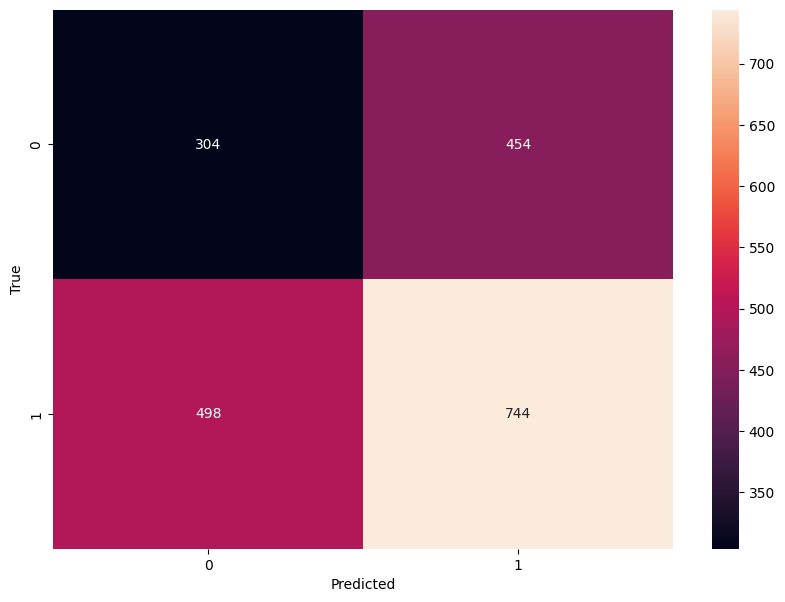

In [55]:
# 혼동행렬



from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [56]:
from sklearn.metrics import classification_report

# 클래스별 성능 지표 출력
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.38      0.40      0.39       758
           1       0.62      0.60      0.61      1242

    accuracy                           0.52      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.52      0.53      2000

